# Final Project
### Teddy Debreu

# Scope Project & Gather Data

In [37]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

## (OPTIONAL) Only run this code if you want to test the import with your credentials
#### You can skip to the marker indicated by *CHECKPOINT*

In [ ]:

host = "pg.mlds.northwestern.edu"  # Replace with actual server name or IP
dbname = "everything2024"
user = ""        # Replace with your username
password = ""    # Replace with your password
port = 5432                   # Default PostgreSQL port

# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=dbname,
        user=user,
        password=password,
        port=port
    )
    print("Connection successful")

    # Define the query
    query = """
    SET search_path TO mlds422;
    SELECT * FROM movies;  -- Replace 'your_table_name' with the actual table
    """

    # Load the data into a pandas DataFrame
    df = pd.read_sql(query, conn)

    # Display the first few rows of the DataFrame
    print(df.head())

    # Close the connection
    conn.close()

except psycopg2.Error as e:
    print("Error while connecting to the database:", e)

In [ ]:
df.to_pickle('movies.pkl')

# *CHECKPOINT*

In [38]:
# Load a DataFrame from a .pkl file
df = pd.read_pickle('movies.pkl')

# Data Cleaning & Exploratory Data Analysis
# 1

Many of the movies have unrealistic release dates, even spanning into the future. I identified those columns on PGAdmin and adjusted them by 100 years, as that was the pattern amongst the data. I also decided to not use the rows in problem #1 if their in_theaters_date was NA, as there was likely an error in data entry or no theatrical release.

In [39]:
# Filter for movies with a valid 'in_theaters_date'
theatrical_movies = df[df['in_theaters_date'].notna()]

# Convert 'in_theaters_date' to datetime format (if not already)
theatrical_movies['in_theaters_date'] = pd.to_datetime(theatrical_movies['in_theaters_date'], errors='coerce')

# Adjust dates: subtract 100 years for movies released in 2020 or later
theatrical_movies['adjusted_date'] = theatrical_movies['in_theaters_date'].apply(
    lambda x: x.replace(year=x.year - 100) if x.year >= 2020 else x
)

# Extract the year from 'adjusted_date'
theatrical_movies['adjusted_year'] = theatrical_movies['adjusted_date'].dt.year

# Filter out unreasonable years (e.g., future years or too old)
valid_movies = theatrical_movies[
    (theatrical_movies['adjusted_year'] >= 1900) & 
    (theatrical_movies['adjusted_year'] <= 2024)
]

# Group by adjusted year and count the number of movies
movies_per_year = valid_movies.groupby('adjusted_year').size()

# Convert to a DataFrame for better readability
movies_per_year_df = movies_per_year.reset_index(name='count')

# Display the summary
print(movies_per_year_df)

# Summary statistics (optional)
print("Year Range:", valid_movies['adjusted_year'].min(), "to", valid_movies['adjusted_year'].max())
print("Total Movies:", valid_movies.shape[0])

    adjusted_year  count
0            1920      5
1            1921      2
2            1922      5
3            1923      5
4            1924      6
..            ...    ...
95           2015    645
96           2016    618
97           2017    582
98           2018    637
99           2019    371

[100 rows x 2 columns]
Year Range: 1920 to 2019
Total Movies: 15823


/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/2083606685.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theatrical_movies['in_theaters_date'] = pd.to_datetime(theatrical_movies['in_theaters_date'], errors='coerce')
/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/2083606685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theatrical_movies['adjusted_date'] = theatrical_movies['in_theaters_date'].apply(
/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_4593

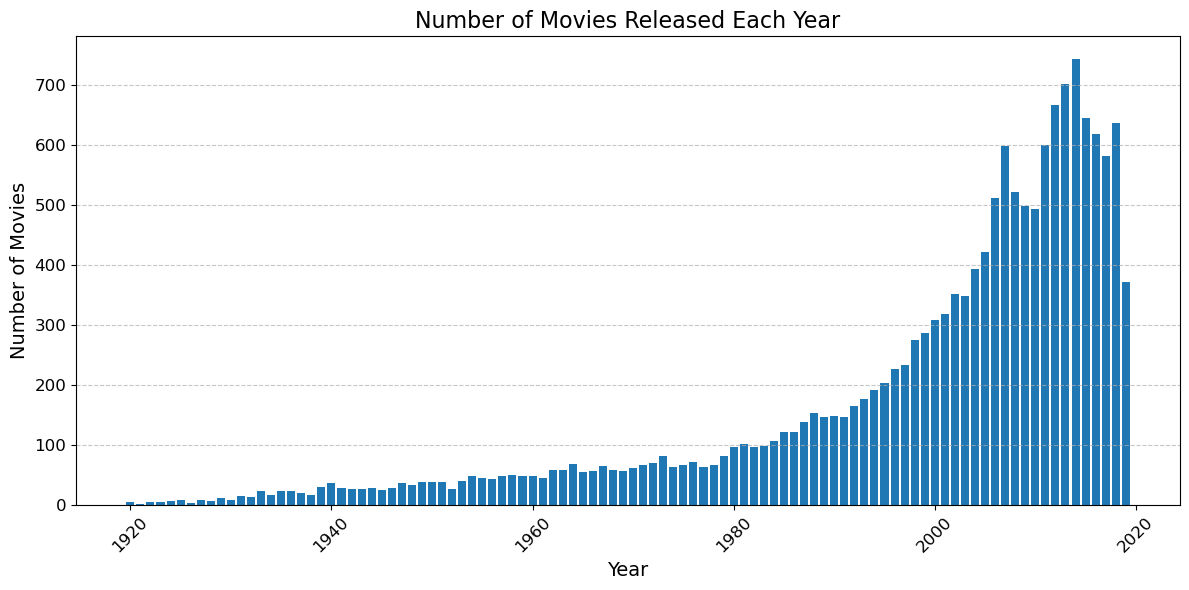

In [40]:
# Visualize the number of movies each year
plt.figure(figsize=(12, 6))
plt.bar(movies_per_year_df['adjusted_year'], movies_per_year_df['count'], width=0.8)
plt.title('Number of Movies Released Each Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


## Explanation

The number of movies released each year shows a clear and significant upward trend over time, reflecting the growth and evolution of the film industry. This growth is likely driven by the industry's massive success and the adoption of transformative technologies such as sound in the late 1920s and color in the 1930s, which revolutionized the viewing experience and drew larger audiences. The steady increase in production through the mid-20th century aligns with the establishment of major film studios and the globalization of cinema, as well as the rise of independent filmmakers who contributed to a more diverse range of content. More recently, the proliferation of digital technologies has dramatically lowered barriers to entry for production, while the rise of streaming platforms has fundamentally altered film distribution, making movies accessible to global audiences instantaneously. This combination of technological innovation and the shifting dynamics of film consumption has fueled the industry's exponential growth, although recent declines in movie releases—particularly after 2020—likely reflect the temporary disruption caused by the COVID-19 pandemic.

For the problem above, I found that there were films that had unrealistic theater releases (in the future). With some querying on PGAdmin, I found that a large group all had the same discrepancy, their year was off by 100 years. I adjusted the year by 100 years for all those specifically.



As I move forward with the analysis, I will address potential duplicates in the dataset by identifying and resolving rows with identical movie_title and in_theaters_date values to ensure the integrity of the data. Assumptions include that duplicates are unintentional and likely stem from data entry errors or overlapping records, and I will either remove them or retain a single entry based on criteria such as the latest release date. Missing or invalid dates will also be handled by filtering out entries where the in_theaters_date is null or falls outside a reasonable range, such as before 1900 or after 2024. Additionally, any adjustments to release years, such as correcting erroneous entries post-2020, will be implemented consistently, ensuring accurate grouping and analysis of movie trends.

# 2

In [41]:
# Adjust the original 'in_theaters_date' column to permanently fix the 100-year discrepancy
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], errors='coerce').apply(
    lambda x: x.replace(year=x.year - 100) if x.year >= 2020 else x
)

# Step 2: Filter for movies released in theaters before 2010 using the adjusted date column
pre_2010_movies = df[df['in_theaters_date'] < '2010-01-01']

# Step 3: Find the 5 highest-rated movies by critics
top_critics = pre_2010_movies.sort_values(by='critic_rating', ascending=False).head(5)

# Step 4: Find the 5 highest-rated movies by the general audience
top_audience = pre_2010_movies.sort_values(by='audience_rating', ascending=False).head(5)

# Step 5: Display results
print("Top 5 Movies by Critic Ratings:")
print(top_critics[['movie_title', 'critic_rating', 'in_theaters_date']])

print("\nTop 5 Movies by Audience Ratings:")
print(top_audience[['movie_title', 'audience_rating', 'in_theaters_date']])

Top 5 Movies by Critic Ratings:
                                  movie_title  critic_rating in_theaters_date
14217  The Great Silence (Il grande silenzio)            100       1968-01-01
3063                           The Band Wagon            100       1953-08-07
534                         The Invisible Man            100       1933-11-13
10164                        Multiple Maniacs            100       1970-04-10
6031       Father (Father: Diary of One Week)            100       1967-10-04

Top 5 Movies by Audience Ratings:
                movie_title  audience_rating in_theaters_date
1846             Ice People            100.0       2008-04-26
222         Prima Ballerina            100.0       2009-01-16
3229  Been Rich All My Life            100.0       2006-07-21
1283   La Ciudad (The City)            100.0       1998-09-13
6747          The Godfather             98.0       1972-03-24


Of all these films, I only know the Godfather! They must be quite niche.

# 3

In [42]:
# Step 1: Filter for movies released in theaters before 2010
pre_2010_movies = df[df['in_theaters_date'] < '2010-01-01']

# Step 2: Calculate the average audience review count for movies before 2010
average_reviews = pre_2010_movies['audience_count'].mean()

# Step 3: Create a new DataFrame for "popular" movies
popular_movies = pre_2010_movies[pre_2010_movies['audience_count'] > average_reviews]

# Step 4: Find the 5 highest-rated movies by critics
top_critics_popular = popular_movies.sort_values(by='critic_rating', ascending=False).head(5)

# Step 5: Find the 5 highest-rated movies by the general audience
top_audience_popular = popular_movies.sort_values(by='audience_rating', ascending=False).head(5)

# Display the results
print("Top 5 Popular Movies by Critic Ratings:")
print(top_critics_popular[['movie_title', 'critic_rating', 'audience_count', 'in_theaters_date']])

print("\nTop 5 Popular Movies by Audience Ratings:")
print(top_audience_popular[['movie_title', 'audience_rating', 'audience_count', 'in_theaters_date']])


Top 5 Popular Movies by Critic Ratings:
          movie_title  critic_rating  audience_count in_theaters_date
11227       Pinocchio            100        279248.0       1940-02-07
15440     Toy Story 2            100        999952.0       1999-11-24
13557  The Terminator            100        775856.0       1984-10-26
9636     Mary Poppins            100        682310.0       1964-08-26
15439       Toy Story            100       1109209.0       1995-11-22

Top 5 Popular Movies by Audience Ratings:
                                          movie_title  audience_rating  \
6747                                    The Godfather             98.0   
12463                        The Shawshank Redemption             98.0   
851                                        GoodFellas             97.0   
6748                           The Godfather, Part II             97.0   
5706   Star Wars: Episode V - The Empire Strikes Back             97.0   

       audience_count in_theaters_date  
6747       

These films make much more sense!

# 4

In [43]:
# Step 1: Calculate the percentage of movies by rating
rating_percentages = popular_movies['rating'].value_counts(normalize=True) * 100

print(rating_percentages)

rating
PG-13    41.583166
R        32.364729
PG       19.639279
G         6.412826
Name: proportion, dtype: float64


In [44]:
# Step 2: Create a summary table with average critic and audience ratings by movie rating
rating_summary = popular_movies.groupby('rating').agg(
    average_critic_rating=('critic_rating', 'mean'),
    average_audience_rating=('audience_rating', 'mean'),
    count=('movie_title', 'size')  # Include a count for context
).reset_index()

print(rating_summary)

  rating  average_critic_rating  average_audience_rating  count
0      G              77.765625                74.781250     64
1     PG              59.316327                65.331633    196
2  PG-13              49.173494                62.590361    415
3      R              61.811146                71.182663    323


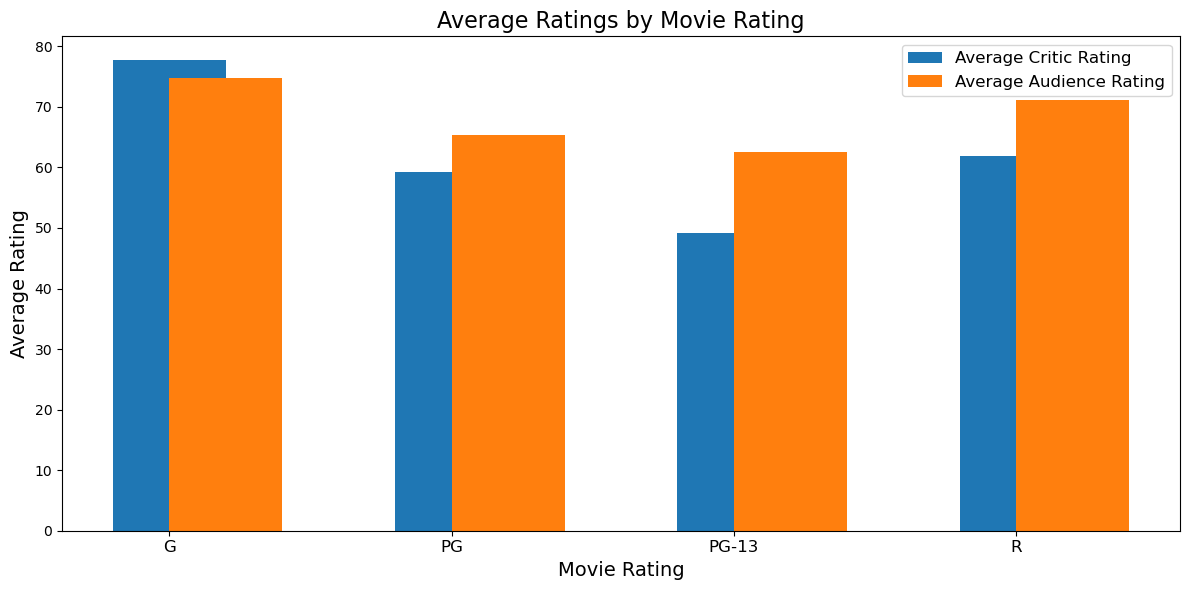

In [45]:
plt.figure(figsize=(12, 6))
x = range(len(rating_summary['rating']))
plt.bar(x, rating_summary['average_critic_rating'], width=0.4, label='Average Critic Rating', align='center')
plt.bar(x, rating_summary['average_audience_rating'], width=0.4, label='Average Audience Rating', align='edge')
plt.xticks(x, rating_summary['rating'], fontsize=12)
plt.title('Average Ratings by Movie Rating', fontsize=16)
plt.xlabel('Movie Rating', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Takeaways

G-rated films consistently receive the highest average ratings from both critics and audiences, showcasing their broad appeal. R-rated films follow closely, but audience ratings tend to surpass critic scores, indicating stronger resonance with viewers. Similarly, PG and PG-13 films also see higher audience ratings compared to critics, but they generally receive lower overall scores, suggesting they are less favorably perceived than G or R-rated movies.

# 5

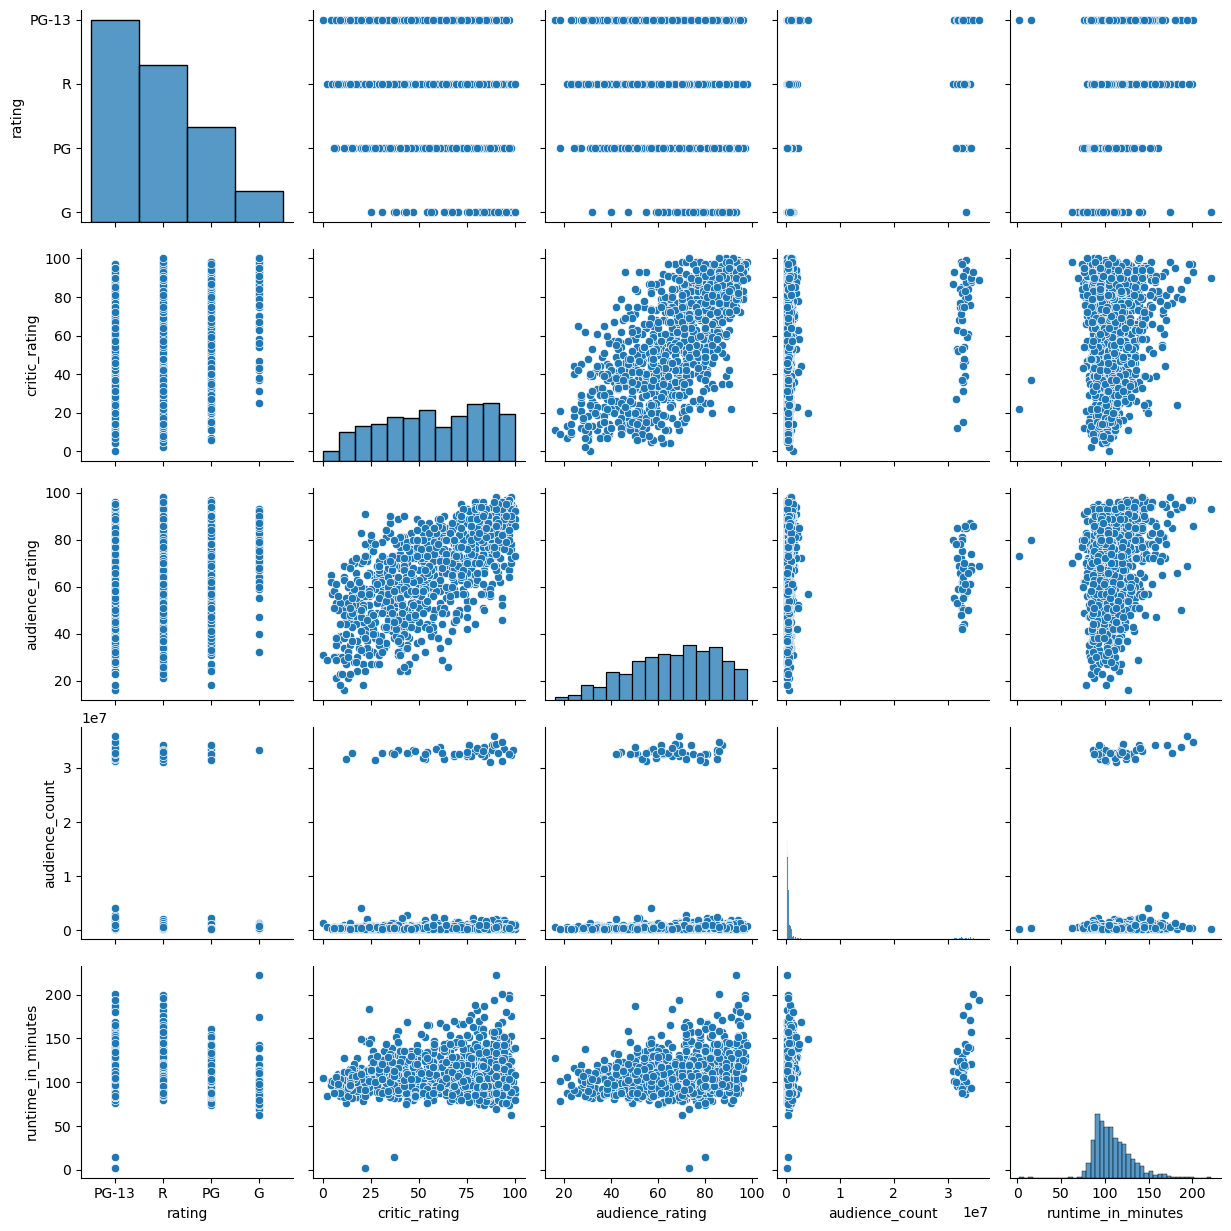

In [46]:
# Step 1: Create a pair plot of relevant columns
pair_plot = sns.pairplot(popular_movies, vars=['rating','critic_rating', 'audience_rating', 'audience_count', 'runtime_in_minutes'])

# Step 2: Display the plot
plt.show()


## Insights
1. Films with longer runtimes tend to receive higher ratings from both audiences and critics, likely because extended time allows for more developed storytelling and character building.

2. Audience and critic ratings show a positive correlation, suggesting that both groups generally align in their evaluations of movies.

3. G-rated films, despite their shorter runtimes, consistently achieve high ratings from both audiences and critics, showcasing their ability to deliver quality within a concise format.

# 6

## Insight 1: Relationship between year and critic rating

/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/1404267487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_movies['release_year'] = pd.to_datetime(popular_movies['in_theaters_date']).dt.year
/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/1404267487.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=popular_movies, x='release_year', y='critic_rating', ci=None)


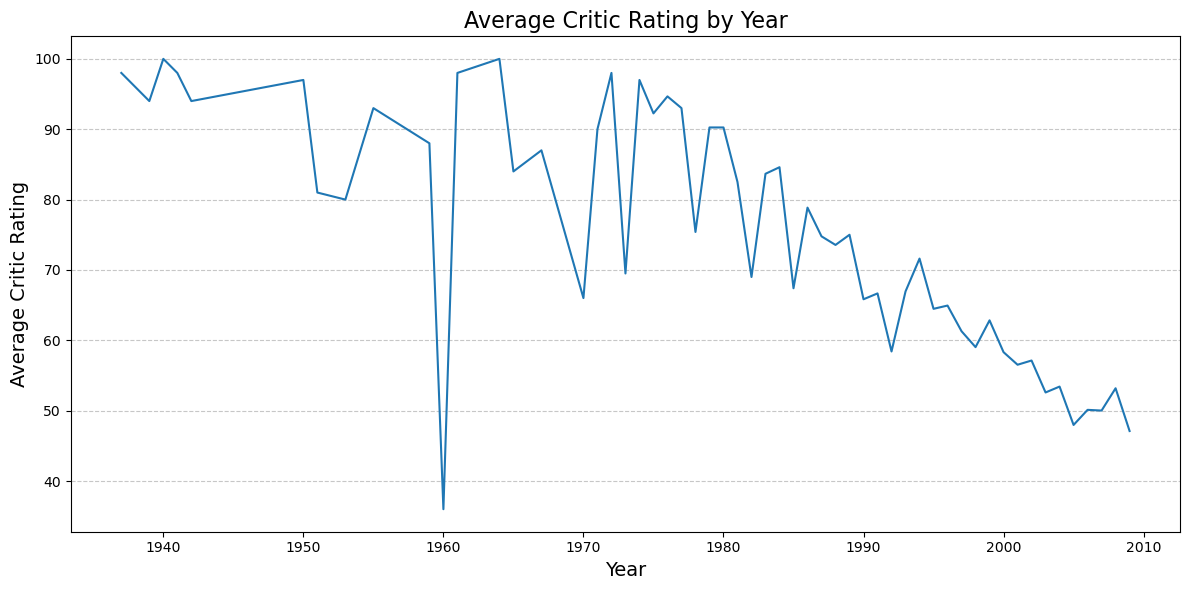

In [47]:
# Step 4: Extract year from 'in_theaters_date' for analysis
popular_movies['release_year'] = pd.to_datetime(popular_movies['in_theaters_date']).dt.year

plt.figure(figsize=(12, 6))
sns.lineplot(data=popular_movies, x='release_year', y='critic_rating', ci=None)
plt.title('Average Critic Rating by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Critic Rating', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The trend of decreasing average critic ratings over time likely reflects a combination of factors. First, as more films are produced, a larger share may be of lower quality, diluting the overall average. Second, there is a selection bias in older films within the dataset—only the "popular" and highly regarded classics tend to remain visible, creating an inflated perception of quality for earlier decades. Additionally, older films likely have lower audience counts, meaning only a subset of the most impactful films from those periods are included, further skewing the ratings toward the best examples of their time.

## Insight 2: Genre vs critic rating (focusing on Drama vs Comedy)

/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/4146200860.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=popular_movies_genre, x='genre', y='critic_rating', palette='Set2')


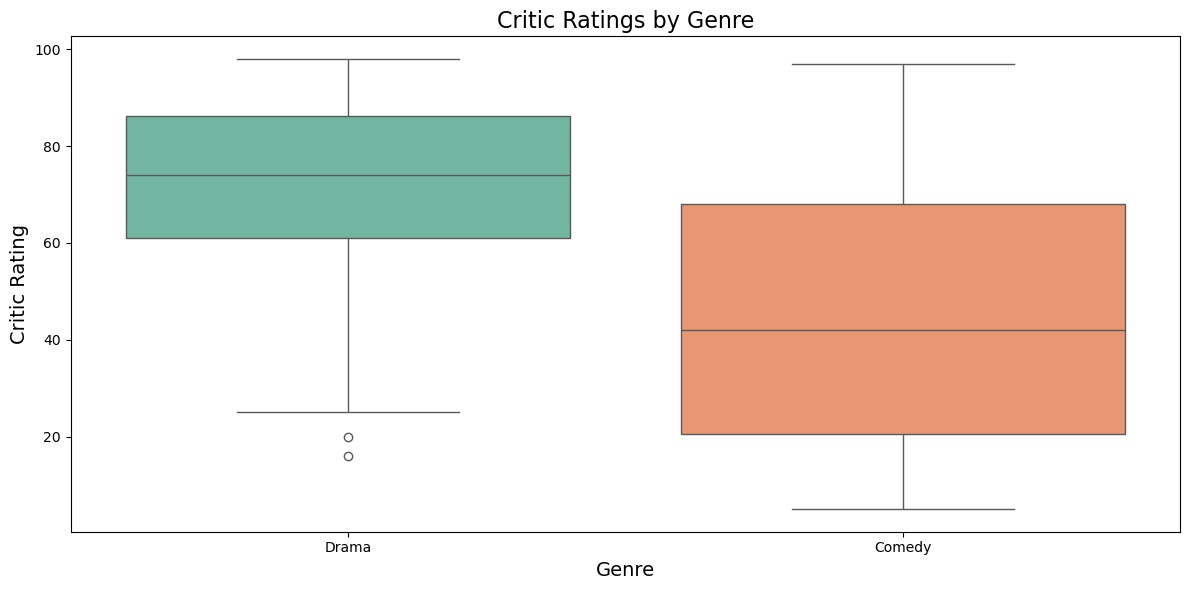

In [48]:
top_genres = ['Drama', 'Comedy']
popular_movies_genre = popular_movies[popular_movies['genre'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=popular_movies_genre, x='genre', y='critic_rating', palette='Set2')
plt.title('Critic Ratings by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Critic Rating', fontsize=14)
plt.tight_layout()
plt.show()

/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/3076639703.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=popular_movies_genre, x='genre', y='audience_rating', palette='Set2')


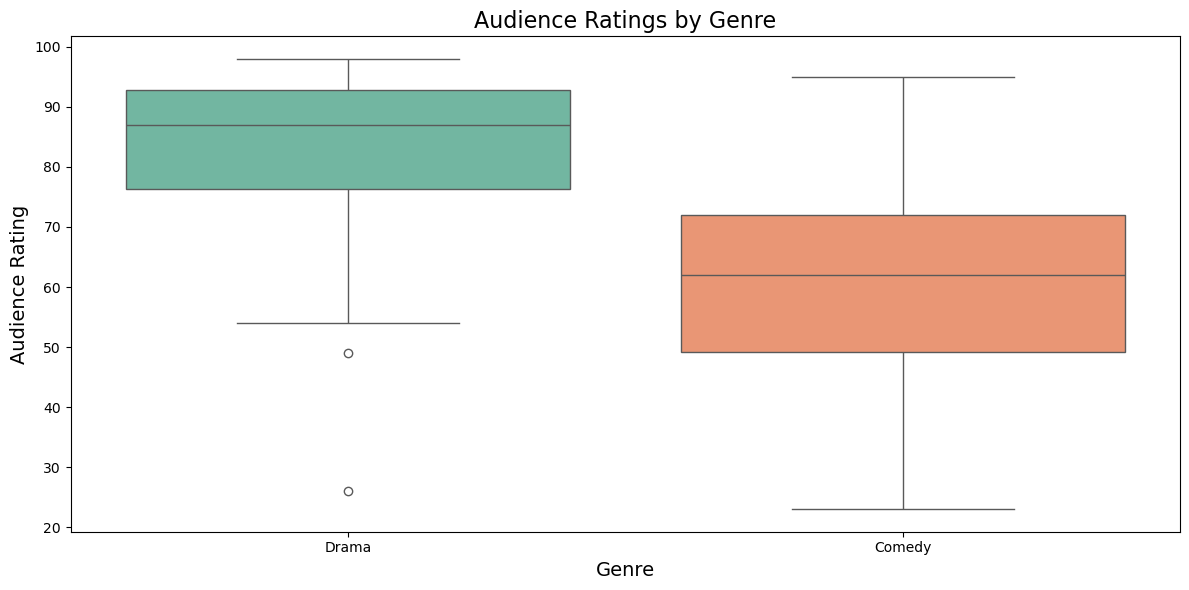

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=popular_movies_genre, x='genre', y='audience_rating', palette='Set2')
plt.title('Audience Ratings by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Audience Rating', fontsize=14)
plt.tight_layout()
plt.show()

The boxplot reveals that both critics and audiences rate comedies lower on average compared to dramas, though the discrepancy is more pronounced with critics. For comedies, the median critic rating is around 40, with a broader range of low scores, while dramas have a median critic rating closer to 75. Similarly, audience ratings for comedies and dramas follow this pattern, with dramas consistently receiving higher scores. This alignment suggests that both critics and audiences perceive dramas as higher-quality, potentially due to their more serious and thought-provoking nature. Comedies, on the other hand, may be seen as less substantive, contributing to their lower evaluations across the board.

## Insight 3: Audience count by season

/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/3536327130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_movies['release_month'] = pd.to_datetime(popular_movies['in_theaters_date']).dt.month
/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/3536327130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_movies['season'] = popular_movies['release_month'].apply(
/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/3536327130.py:13: FutureWarning

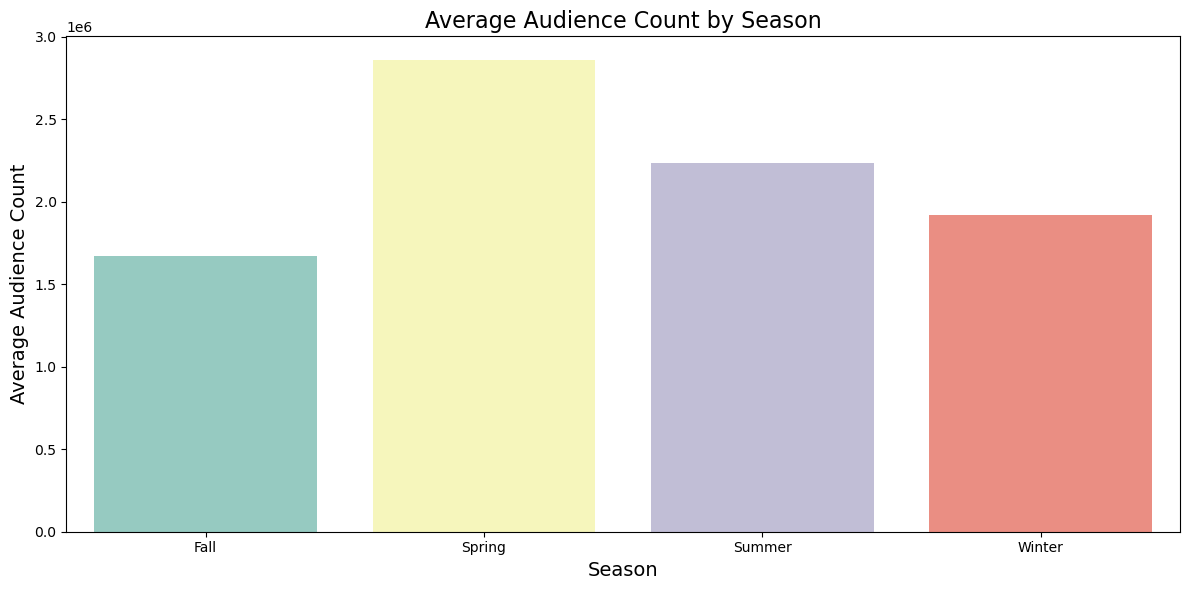

In [50]:
# extracting month from 'in_theaters_date')
popular_movies['release_month'] = pd.to_datetime(popular_movies['in_theaters_date']).dt.month
popular_movies['season'] = popular_movies['release_month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
              'Spring' if x in [3, 4, 5] else
              'Summer' if x in [6, 7, 8] else
              'Fall'
)

season_audience = popular_movies.groupby('season')['audience_count'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=season_audience, x='season', y='audience_count', palette='Set3')
plt.title('Average Audience Count by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Audience Count', fontsize=14)
plt.tight_layout()
plt.show()

The visualization shows that spring has the highest average audience count, followed by summer, while fall and winter see significantly lower engagement. This trend suggests that films released in spring and summer, often blockbuster-heavy periods, attract larger audiences compared to the quieter fall and winter seasons. The higher engagement in these seasons could be attributed to vacation periods, increased marketing for major releases, and favorable weather encouraging cinema outings.

# Feature Engineering
# 7

In [51]:
# Step 1: Ensure the original dataset has the erroneous years fixed
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], errors='coerce').apply(
    lambda x: x.replace(year=x.year - 100) if x.year >= 2020 else x
)

# Step 2: Extract year from 'in_theaters_date' for splitting
df['release_year'] = df['in_theaters_date'].dt.year

# Step 5: Split the data into training and test sets based on release year
train_data = df[df['release_year'] < 2010]  # Movies released before 2010
test_data = df[df['release_year'] >= 2010]  # Movies released in 2010 and after

# Fill missing values in train_data and test_data before further processing
train_data['runtime_in_minutes'] = train_data['runtime_in_minutes'].fillna(train_data['runtime_in_minutes'].mean())
test_data['runtime_in_minutes'] = test_data['runtime_in_minutes'].fillna(test_data['runtime_in_minutes'].mean())

train_data['genre'] = train_data['genre'].fillna('Unknown')  # Avoid losing rows due to missing genre
test_data['genre'] = test_data['genre'].fillna('Unknown')

# Display sizes of the datasets
print(f"Training Data Size (Popular Movies): {train_data.shape[0]}")
print(f"Test Data Size (Popular Movies): {test_data.shape[0]}")

Training Data Size (Popular Movies): 9764
Test Data Size (Popular Movies): 6059


/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/3098456672.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['runtime_in_minutes'] = train_data['runtime_in_minutes'].fillna(train_data['runtime_in_minutes'].mean())
/var/folders/c1/d258m0j547x79yhr4zpkyz3r0000gn/T/ipykernel_45935/3098456672.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['runtime_in_minutes'] = test_data['runtime_in_minutes'].fillna(test_data['runtime_in_minutes'].mean())
/var/folders/c1/d258m0j54

# 8

Columns to Exclude:
1. critic_rating: This is the target variable we are predicting.
2. audience_rating: Audience ratings are only available after release, so they cannot be used for upfront predictions.
3. critic_count: The number of critic reviews is not available before release.
4. audience_count: The number of audience reviews is also not available before release.
5. movie_info: This is an informational string and won't provide anything to the model.
6. movie_id: Unnecessary indexing column
7. director: Unnecessary string


In [52]:
# Training data
X_train = train_data.drop(columns=['critic_rating', 'audience_rating', 'critic_count', 'audience_count', 'movie_info', 'movie_id','directors'])  # Drop irrelevant features, not critic_rating
y_train = train_data['critic_rating']  # Target variable for training

# Test data
exclude_columns_test = ['critic_rating', 'audience_rating', 'critic_count', 'audience_count', 'movie_info', 'movie_id','directors']
X_test = test_data.drop(columns=exclude_columns_test)  # Exclude unavailable features from test
y_test = test_data['critic_rating']  # Target variable for testing

In [53]:
# Check shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Check for missing values
print("Missing values in X_train:\n", X_train.isnull().sum())
print("Missing values in X_test:\n", X_test.isnull().sum())
print("Missing values in y_train:", y_train.isnull().sum())
print("Missing values in y_test:", y_test.isnull().sum())


X_train shape: (9764, 7), y_train shape: (9764,)
X_test shape: (6059, 7), y_test shape: (6059,)
Missing values in X_train:
 movie_title              0
rating                1990
genre                    0
in_theaters_date         0
on_streaming_date        0
runtime_in_minutes       0
release_year             0
dtype: int64
Missing values in X_test:
 movie_title              0
rating                2321
genre                    0
in_theaters_date         0
on_streaming_date        0
runtime_in_minutes       0
release_year             0
dtype: int64
Missing values in y_train: 0
Missing values in y_test: 0


# 9

In [54]:
# Step 1: Replace NaN in the rating column with 'Unknown'
X_train['rating'] = X_train['rating'].fillna('Unknown')
X_test['rating'] = X_test['rating'].fillna('Unknown')

# Step 2: Clean up extra spaces in the genre strings
X_train['genre'] = X_train['genre'].str.replace(', ', ',').str.strip()
X_test['genre'] = X_test['genre'].str.replace(', ', ',').str.strip()

# Step 3: One-hot encode genres directly
genre_dummies_train = X_train['genre'].str.get_dummies(sep=',').add_prefix('genre_')
genre_dummies_test = X_test['genre'].str.get_dummies(sep=',').add_prefix('genre_')

# Step 4: Merge dummy variables back into the original datasets
X_train = pd.concat([X_train, genre_dummies_train], axis=1).drop(columns=['genre'])
X_test = pd.concat([X_test, genre_dummies_test], axis=1).drop(columns=['genre'])

# Step 5: Add the "kid_friendly" column
X_train['kid_friendly'] = X_train['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)
X_test['kid_friendly'] = X_test['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)

# Step 6: Add a binary column for unknown ratings
X_train['unknown_rating'] = X_train['rating'].apply(lambda x: 1 if x == 'Unknown' else 0)
X_test['unknown_rating'] = X_test['rating'].apply(lambda x: 1 if x == 'Unknown' else 0)

# Step 7: Align columns between train and test datasets
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# Display the updated datasets
print("Updated Training Features Shape:", X_train.shape)
print("Updated Test Features Shape:", X_test.shape)

# Preview columns of interest
print("Training Features with kid_friendly and unknown_rating:")
print(X_train[['rating', 'kid_friendly', 'unknown_rating']].head())

print("Test Features with kid_friendly and unknown_rating:")
print(X_test[['rating', 'kid_friendly', 'unknown_rating']].head())


Updated Training Features Shape: (9764, 30)
Updated Test Features Shape: (6059, 30)
Training Features with kid_friendly and unknown_rating:
    rating  kid_friendly  unknown_rating
2        R             0               0
3  Unknown             0               1
4        G             1               0
5    PG-13             0               0
6  Unknown             0               1
Test Features with kid_friendly and unknown_rating:
    rating  kid_friendly  unknown_rating
0       PG             1               0
1        R             0               0
101      R             0               0
134  PG-13             0               0
136      R             0               0


# 10

### Interaction Between Runtime and Drama
This feature combines runtime with the Drama genre, capturing the hypothesis that longer dramas often delve into deeper, more complex narratives, which critics may favor.
Potential Impact: Medium. Dramatic films with extended runtimes often receive acclaim for their storytelling depth.

### Interaction Between Faith and Comedy
The interaction between Faith & Spirituality and Comedy represents a unique combination that might resonate differently with critics. For example, films blending faith-based themes with humor could stand out as innovative or polarizing.
Potential Impact: Medium. The rarity of this combination could make it a strong differentiator, albeit for a smaller subset of films.

### Interaction Between Runtime and Kid-Friendly
This feature multiplies runtime by kid_friendly, hypothesizing that longer kid-friendly films (e.g., animated blockbusters) may garner higher ratings due to their ability to hold attention across audiences.
Potential Impact: Medium. The relationship could vary depending on whether longer runtimes positively or negatively affect children-oriented content.

### Genre Scope (Count of Genres)
This feature sums the number of genres associated with a movie, reflecting its breadth. Films with more genres may appeal to wider audiences or risk being unfocused, which could impact critic ratings.
Potential Impact: Medium. Critics may view genre diversity as a sign of ambition or lack of coherence, depending on execution.



In [55]:

# Define Feature 1: Interaction between runtime and 'Drama' genre, between runtime and 'Comedy' genre
X_train['runtime_drama'] = X_train['runtime_in_minutes'] * X_train.get('genre_Drama', 0)
X_test['runtime_drama'] = X_test['runtime_in_minutes'] * X_test.get('genre_Drama', 0)

X_train['faith_comedy'] = X_train.get('genre_Faith & Spirituality', 0) * X_train.get('genre_Comedy', 0)
X_test['faith_comedy'] = X_test.get('genre_Faith & Spirituality', 0) * X_test.get('genre_Comedy', 0)

X_train['runtime_kid_friendly'] = X_train['runtime_in_minutes'] * X_train['kid_friendly']
X_test['runtime_kid_friendly'] = X_test['runtime_in_minutes'] * X_test['kid_friendly']

genre_columns = [col for col in X_train.columns if col.startswith('genre_') and col != 'genre_scope'] # new addition
X_train['genre_scope'] = X_train[genre_columns].sum(axis=1)
X_test['genre_scope'] = X_test[genre_columns].sum(axis=1)

# 11

Done

# 12

In [56]:
# Step 1: Drop non-numeric columns (e.g., movie_title) from training and test sets
numeric_columns = X_train.select_dtypes(include=['number']).columns
X_train_clean = X_train[numeric_columns]
X_test_clean = X_test[numeric_columns]

# Step 2: Handle missing values by filling them with 0
X_train_clean = X_train_clean.fillna(0)
X_test_clean = X_test_clean.fillna(0)

# Display the cleaned datasets
print("Cleaned Training Features Shape:", X_train_clean.shape)
print("Cleaned Test Features Shape:", X_test_clean.shape)

# Check for any remaining missing values
print("Missing values in X_train_clean:", X_train_clean.isnull().sum().sum())
print("Missing values in X_test_clean:", X_test_clean.isnull().sum().sum())


Cleaned Training Features Shape: (9764, 30)
Cleaned Test Features Shape: (6059, 30)
Missing values in X_train_clean: 0
Missing values in X_test_clean: 0


In [57]:
# Handle missing values in y_train and y_test (only if necessary)
if y_train.isnull().sum() > 0:
    y_train = y_train.fillna(y_train.mean())  # Fill missing values with the mean of the target variable
if y_test.isnull().sum() > 0:
    y_test = y_test.fillna(y_test.mean())  # Do the same for the test target

# Ensure alignment between features and target variables
X_train_clean, y_train = X_train_clean.align(y_train, join='inner', axis=0)
X_test_clean, y_test = X_test_clean.align(y_test, join='inner', axis=0)

# Final validation
print(f"Final X_train_clean shape: {X_train_clean.shape}, y_train shape: {y_train.shape}")
print(f"Final X_test_clean shape: {X_test_clean.shape}, y_test shape: {y_test.shape}")

# Check for remaining missing values in the targets
print("Remaining missing values in y_train:", y_train.isnull().sum())
print("Remaining missing values in y_test:", y_test.isnull().sum())


Final X_train_clean shape: (9764, 30), y_train shape: (9764,)
Final X_test_clean shape: (6059, 30), y_test shape: (6059,)
Remaining missing values in y_train: 0
Remaining missing values in y_test: 0


# 13

In [58]:
# Define feature subsets for each model
# Model 1: Use only runtime_in_minutes
X_train_model1 = X_train_clean[['runtime_in_minutes']]

# Model 2: Use runtime_in_minutes and kid_friendly
X_train_model2 = X_train_clean[['runtime_in_minutes', 'kid_friendly']]

# Model 3: Use runtime_in_minutes, kid_friendly, and all genre dummy columns (excluding genre_scope)
genre_columns = [col for col in X_train_clean.columns if col.startswith('genre_') and col != 'genre_scope']
X_train_model3 = X_train_clean[['runtime_in_minutes', 'kid_friendly'] + genre_columns]
X_test_model3 = X_test_clean[['runtime_in_minutes', 'kid_friendly'] + genre_columns]

# Initialize and fit models
model1 = LinearRegression().fit(X_train_model1, y_train)
model2 = LinearRegression().fit(X_train_model2, y_train)
model3 = LinearRegression().fit(X_train_model3, y_train)

# Display models' coefficients
print("Model 1 Coefficients:", model1.coef_)
print("Model 2 Coefficients:", model2.coef_)
print("Model 3 Coefficients:", model3.coef_)


Model 1 Coefficients: [0.09859004]
Model 2 Coefficients: [0.09899158 2.52311397]
Model 3 Coefficients: [  0.07413165   2.83775222  -5.39145527  11.99570853  -4.34866836
  12.58375459  22.92526205  -4.54775991   2.59819799  21.10331057
   7.95640071 -10.92261753  -4.55416642  -5.68083824  -3.72026834
   3.77642419  -1.53436524   1.42267464   1.37752928   6.65286479
   2.99453442   4.69058237  22.58521436   6.40652774]


In [59]:
# Define a function to score models
def score_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {"R²": r2, "MAE": mae, "RMSE": rmse}

# Prepare test feature subsets for each model
X_test_model1 = X_test_clean[['runtime_in_minutes']]
X_test_model2 = X_test_clean[['runtime_in_minutes', 'kid_friendly']]
X_test_model3 = X_test_clean[['runtime_in_minutes', 'kid_friendly'] + genre_columns]

# Predict using each model
y_pred_model1 = model1.predict(X_test_model1)
y_pred_model2 = model2.predict(X_test_model2)
y_pred_model3 = model3.predict(X_test_model3)

# Score each model
scores_model1 = score_model(y_test, y_pred_model1)
scores_model2 = score_model(y_test, y_pred_model2)
scores_model3 = score_model(y_test, y_pred_model3)

# Display scores
print("Model 1 Scores:", scores_model1)
print("Model 2 Scores:", scores_model2)
print("Model 3 Scores:", scores_model3)

Model 1 Scores: {'R²': 0.001532808716624312, 'MAE': 24.364339426001774, 'RMSE': 28.312794737647256}
Model 2 Scores: {'R²': 0.0012644001783518322, 'MAE': 24.40195641618294, 'RMSE': 28.316600013006525}
Model 3 Scores: {'R²': 0.1506546877929381, 'MAE': 22.0408164523866, 'RMSE': 26.113073311437496}


# 15

Model 3 is the best-performing model (although none of them are great). It achieves the highest R² (0.15065), indicating that it explains ~15% of the variance in the target variable (critic_rating). It has the lowest MAE (22.04), meaning it predicts closer to actual values on average. It also has the lowest RMSE (26.1), showing better overall prediction accuracy compared to Models 1 and 2.

Model 3 uses all available features: runtime_in_minutes, kid_friendly, and the one-hot encoded genre columns. These additional features (particularly genres) seem to greatly improve the model's ability to predict critic_rating.

In [60]:
# Add a constant for the intercept
X_train_model3_with_const = sm.add_constant(X_train_model3)

# Fit the statsmodels OLS regression
ols_model = sm.OLS(y_train, X_train_model3_with_const).fit()

# Display the summary, including p-values
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     120.0
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:42:44   Log-Likelihood:                -45358.
No. Observations:                9764   AIC:                         9.077e+04
Df Residuals:                    9739   BIC:                         9.095e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

### Summary of Significant Features
#### Positive Predictors: 
runtime_in_minutes, genre_Art House & International, genre_Documentary, genre_Classics, genre_Animation, genre_Drama.
#### Negative Predictors: 
genre_Comedy, genre_Faith & Spirituality, genre_Horror, genre_Kids & Family, genre_Action & Adventure, and genre_Science Fiction & Fantasy.

# 16

#### Model 4

In [61]:
#X_train_model4 = X_train_clean[['runtime_in_minutes', 'kid_friendly',  'runtime_drama', 'runtime_comedy'] + genre_columns]
#X_test_model4 = X_test_clean[['runtime_in_minutes', 'kid_friendly', 'runtime_drama', 'runtime_comedy'] + genre_columns]

X_train_model4 = X_train_clean[['runtime_in_minutes', 'kid_friendly',  'runtime_kid_friendly'] + genre_columns]
X_test_model4 = X_test_clean[['runtime_in_minutes', 'kid_friendly', 'runtime_kid_friendly'] + genre_columns]


In [62]:
# Function to train and evaluate a model
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "R²": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    }

# Train and evaluate Model 4
scores_model4 = train_and_evaluate_model(X_train_model4, X_test_model4, y_train, y_test)

print("Model 4 Scores:", scores_model4)

Model 4 Scores: {'R²': 0.15114907027240287, 'MAE': 22.032771582235625, 'RMSE': 26.105472324585957}


In [63]:
# Add a constant for the intercept
X_train_model4_with_const = sm.add_constant(X_train_model4)

# Fit the statsmodels OLS regression
ols_model = sm.OLS(y_train, X_train_model4_with_const).fit()

# Display the summary, including p-values
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     115.3
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:42:45   Log-Likelihood:                -45357.
No. Observations:                9764   AIC:                         9.077e+04
Df Residuals:                    9738   BIC:                         9.095e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Family-friendly movies with appropriate runtimes may score higher with critics. For example:
Short kid-friendly movies might be seen as concise and well-paced.
Long kid-friendly movies might either be appreciated for their depth (e.g., Pixar films) or penalized for overstaying their welcome.
Non-kid-friendly movies (where kid_friendly=0) won't be affected by this feature because the interaction will always be 0.

#### Model 5

In [64]:
X_train_model5 = X_train_clean[['runtime_in_minutes', 'genre_scope', 'runtime_drama', 'faith_comedy'] + genre_columns]
X_test_model5 = X_test_clean[['runtime_in_minutes', 'genre_scope', 'runtime_drama', 'faith_comedy'] + genre_columns]

In [65]:
# Train and evaluate Model 4
scores_model5 = train_and_evaluate_model(X_train_model5, X_test_model5, y_train, y_test)

print("Model 5 Scores:", scores_model5)

Model 5 Scores: {'R²': 0.15362081787631887, 'MAE': 22.00084046644842, 'RMSE': 26.067436682561418}


In [66]:
# Add a constant for the intercept
X_train_model5_with_const = sm.add_constant(X_train_model5)

# Fit the statsmodels OLS regression
ols_model = sm.OLS(y_train, X_train_model5_with_const).fit()

# Display the summary, including p-values
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     115.2
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:42:46   Log-Likelihood:                -45358.
No. Observations:                9764   AIC:                         9.077e+04
Df Residuals:                    9738   BIC:                         9.096e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

The model includes runtime_in_minutes as a core feature, capturing the relationship between movie length and critic ratings. Genre_scope measures the diversity of genres in a movie, reflecting its breadth and potential appeal. Runtime_drama explores the interaction between runtime and dramatic storytelling, hypothesizing that longer dramas resonate more with critics. Faith_comedy captures the unique combination of faith-based and comedic elements, which may influence ratings due to their novelty or niche appeal. Finally, individual genre dummy variables are included to account for specific genre effects on critic evaluations.

I took out runtime_kid_friendly and kid_friendly to isolate the positive effects.

#### Model 6

In [67]:
X_train_model6 = X_train_clean[['runtime_in_minutes', 'runtime_drama', 'genre_Comedy', 'genre_Faith & Spirituality', 
                              'genre_Horror', 'genre_Kids & Family', 'genre_Action & Adventure', 'genre_Science Fiction & Fantasy',
                              'genre_Art House & International', 'genre_Documentary', 'genre_Classics', 
                              'genre_Animation', 'genre_Drama']]
X_test_model6 = X_test_clean[['runtime_in_minutes', 'runtime_drama', 'genre_Comedy', 'genre_Faith & Spirituality', 
                              'genre_Horror', 'genre_Kids & Family', 'genre_Action & Adventure', 'genre_Science Fiction & Fantasy',
                              'genre_Art House & International', 'genre_Documentary', 'genre_Classics', 
                              'genre_Animation', 'genre_Drama']]

# Train and evaluate Model 4
scores_model6 = train_and_evaluate_model(X_train_model6, X_test_model6, y_train, y_test)

print("Model 6 Scores:", scores_model6)

Model 6 Scores: {'R²': 0.1662821787167439, 'MAE': 21.72897637980723, 'RMSE': 25.871724827365412}


In [68]:
# Add a constant for the intercept
X_train_model6_with_const = sm.add_constant(X_train_model6)

# Fit the statsmodels OLS regression
ols_model = sm.OLS(y_train, X_train_model6_with_const).fit()

# Display the summary, including p-values
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     215.1
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:42:47   Log-Likelihood:                -45391.
No. Observations:                9764   AIC:                         9.081e+04
Df Residuals:                    9750   BIC:                         9.091e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In Model 6, the focus is on statistically significant genres to reduce noise and isolate the effects of key predictors. Runtime_in_minutes remains a core feature, capturing the relationship between movie length and critic ratings. The interaction term runtime_drama is included to explore how longer dramas, often associated with depth and complexity, influence ratings. Specific genres such as Comedy, Drama, Horror, and Art House & International are retained due to their statistical significance, ensuring the model captures their distinct contributions to critic evaluations. Additionally, genres like Faith & Spirituality, Kids & Family, and Science Fiction & Fantasy account for variations in critic reception across niche and broad audience appeals. Interaction terms and non-significant genres were removed to simplify the model and focus on individual predictors, improving clarity and reducing potential overfitting.

# 17

Model 6 performs the best among all the models, achieving the highest R² (0.166) and the lowest MAE (21.73) and RMSE (25.87). These metrics indicate that Model 6 captures the most variability in critic ratings while minimizing error. Features such as runtime_in_minutes and runtime_drama show strong predictive power, with significant positive coefficients and low p-values, highlighting their importance in influencing critic ratings. Among genres, Art House & International, Documentary, and Science Fiction & Fantasy positively contribute to critic ratings, as indicated by their significant and high coefficients. On the other hand, genres like Comedy, Horror, and Faith & Spirituality negatively impact critic ratings, with significant negative coefficients. The removal of irrelevant features and noise in this model further enhances its performance, demonstrating the importance of focusing on statistically significant predictors.

# 18

### 1. Explore Nonlinear Relationships
Use polynomial or logarithmic transformations of runtime_in_minutes or other continuous predictors to capture potential nonlinear effects (e.g., diminishing returns for extremely long runtimes). For instance, adding runtime_in_minutes² could account for critics penalizing overly long films.

### 2. Incorporate Additional Data
Include new features such as:
Audience Metrics: Ratings from viewers and viewer counts could provide complementary insight into critical reception.
Production Features: Director reputation may have a significant impact on critic ratings (based on audience count).
Temporal Trends: Use the release year or seasonal effects to account for changes in critic preferences over time. For example, dramas released during awards season might score higher.

### 3. Add Regularization to the Model
Introduce Lasso or Ridge Regression to improve the model by penalizing less important coefficients. Regularization would help manage multicollinearity between features (e.g., overlapping genre effects) and eliminate insignificant predictors automatically, allowing the model to focus on the most impactful features.